<h1>Projet 7 - Implémentez un modèle de scoring<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminary" data-toc-modified-id="Preliminary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminary</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Graphics-and-Options" data-toc-modified-id="Graphics-and-Options-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Graphics and Options</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model selection</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Creating-MLFlow-experiment" data-toc-modified-id="Creating-MLFlow-experiment-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Creating MLFlow experiment</a></span></li><li><span><a href="#Handling-imbalanced-data" data-toc-modified-id="Handling-imbalanced-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Handling imbalanced data</a></span></li><li><span><a href="#Rebalancing-data" data-toc-modified-id="Rebalancing-data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Rebalancing data</a></span></li><li><span><a href="#Baseline-with-several-classifiers" data-toc-modified-id="Baseline-with-several-classifiers-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Baseline with several classifiers</a></span></li></ul></li></ul></div>

<div class ="alert alert-block alert-info">
    <b>Notebook : Modelisation</b>
</div>

# Preliminary

## Imports

Nous utilisons un environnement spécifique créé pour le projet : "mlfow_env". Nous avons effectué les installations des librairies requises.

Nous importons les librairies nécessaires :

In [9]:
import os

import gc
import time
import timeit
import re
import warnings
from contextlib import contextmanager
from collections import Counter
import os
import pickle
import dill

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     HalvingGridSearchCV, cross_validate, RandomizedSearchCV,
                                     cross_val_predict, cross_val_score, RepeatedStratifiedKFold)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay,
                             classification_report, make_scorer)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

import xgboost as xgb
import lightgbm as ltb

from lime import lime_tabular
import shap

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

import mlflow
from mlflow import log_metric, log_param, log_artifacts
import mlflow.sklearn

from sklearn.metrics import roc_curve, auc
from collections import Counter
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import lime
import random
import shap
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

warnings.simplefilter(action='ignore', category=FutureWarning)

## Graphics and Options

Nous définissons le style Seaborn par défaut : 

In [10]:
sns.set(style="whitegrid")

## Functions

In [33]:
# Fonction pour enregistrer le modèle dans MLflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None, X_train=None, y_train=None, X_test=None, y_test=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Start timing
        start_time = time.time()

        # Fit the model
        model.fit(X_train, y_train)

        # Calculate processing time
        end_time = time.time()
        processing_time = end_time - start_time
        mlflow.log_metric("Processing_Time_seconds", processing_time)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        mlflow.log_metric("AUC", roc_auc)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save ROC curve as artifact
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()


In [12]:
# Fonction pour afficher la matrice de confusion
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [13]:
# Fonction pour calculer le score métier
def fc_business_score(y_true, y_pred):

    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    TP = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    FN = mat_conf[1, 0]
    # Nombre de Faux Positifs
    FP = mat_conf[0, 1]
    # Nombre de True Positifs
    TN = mat_conf[1, 1]
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = -1        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = float((gain_total - gain_minumun) / (gain_maximun - gain_minumun))
    
    return score

In [14]:
# Fonction pour tracer la variance expliquée de l'ACP
def scree_plot():

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot of PCA: Component Eigenvalues')
    show()

In [15]:
# Fonction pour tracer le ratio de variance expliquée
def var_explained():

    ax = figure().gca()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(x=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Explained Variance of PCA by Component')
    show()

# Model selection

## Loading data

In [16]:
# Charger le dataset target
dataset_target = pd.read_csv("./data/cleaned/dataset_target.csv")
dataset_target

,index,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
0,0,1.0,0,0,0,0,202500.0,406597.5,24700.5,0.018801,...,1.000000,0.000,0.0000,0.000,0.000000e+00,53093.746,11559.2470,219625.690,9251.775,-5993.0
1,1,0.0,1,0,1,0,270000.0,1293502.5,35698.5,0.003541,...,1.000000,0.000,0.0000,0.000,0.000000e+00,560835.400,64754.5860,1618864.600,6662.970,-34633.0
2,2,0.0,0,1,0,0,67500.0,135000.0,6750.0,0.010032,...,1.000000,0.000,0.0000,0.000,0.000000e+00,10573.965,7096.1550,21288.465,5357.250,-2285.0
3,3,0.0,1,0,0,0,135000.0,312682.5,29686.5,0.008019,...,1.000000,0.000,0.0000,0.000,0.000000e+00,691786.900,62947.0900,1007153.440,2482.920,-4346.0
4,4,0.0,0,0,0,0,121500.0,513000.0,21865.5,0.028663,...,0.954545,22655.654,452.3843,29857.365,8.084830e+06,22678.785,12666.4440,835985.300,0.180,-68128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307506,0.0,0,0,1,0,157500.0,254700.0,27558.0,0.032561,...,1.000000,0.000,0.0000,0.000,0.000000e+00,12815.010,7492.9243,52450.470,6605.910,-1094.0
307503,307507,0.0,1,0,0,0,72000.0,269550.0,12001.5,0.025164,...,1.000000,0.000,0.0000,0.000,0.000000e+00,10074.465,10069.8670,60419.203,10046.880,-14363.0
307504,307508,0.0,1,0,0,0,153000.0,677664.0,29979.0,0.005002,...,0.928571,3945.825,283.7925,3973.095,1.110980e+06,5575.185,4399.7080,61595.910,27.270,-33424.0
307505,307509,1.0,1,0,0,0,171000.0,370107.0,20205.0,0.005313,...,1.000000,0.000,0.0000,0.000,0.000000e+00,19065.824,10239.8330,194556.830,2296.440,-3064.0


In [17]:
# Charger le dataset predict
dataset_predict = pd.read_csv("./data/cleaned/dataset_predict.csv")
dataset_predict

,index,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
0,0,NaN,1,0,0,0,135000.0,568800.0,20560.5,0.018850,...,1.000000,0.00,0.0000,0.000,0.000000e+00,17397.900,5885.1323,41195.926,3951.000,-15365.0
1,1,NaN,0,0,0,0,99000.0,222768.0,17370.0,0.035792,...,1.000000,0.00,0.0000,0.000,0.000000e+00,17656.244,6240.2050,56161.844,4813.200,-5486.0
2,2,NaN,0,1,0,0,202500.0,663264.0,69777.0,0.019101,...,0.935484,23147.82,1157.6627,179437.720,2.346772e+07,357347.750,10897.8980,1689174.200,6.165,-210507.0
3,3,NaN,1,0,0,2,315000.0,1575000.0,49018.5,0.026392,...,0.911504,8505.00,622.5507,70348.230,2.972476e+06,38988.540,4979.2820,562658.900,1.170,-97016.0
4,4,NaN,0,1,1,1,180000.0,625500.0,32067.0,0.010032,...,1.000000,0.00,0.0000,0.000,0.000000e+00,11100.600,11100.3380,133204.050,11097.450,-7611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,48739,NaN,1,0,0,0,121500.0,412560.0,17473.5,0.002042,...,1.000000,0.00,0.0000,0.000,0.000000e+00,244664.500,91036.4500,273109.380,14222.430,-1891.0
48740,48740,NaN,1,0,1,2,157500.0,622413.0,31909.5,0.035792,...,0.958904,9680.49,314.7146,22974.164,2.023069e+06,14571.765,8086.1620,590289.800,2.700,-72468.0
48741,48741,NaN,1,1,0,1,202500.0,315000.0,33205.5,0.026392,...,1.000000,0.00,0.0000,0.000,0.000000e+00,81184.010,23158.9920,185271.940,12640.950,-4691.0
48742,48742,NaN,0,0,1,0,225000.0,450000.0,25128.0,0.018850,...,1.000000,0.00,0.0000,0.000,0.000000e+00,23451.705,17269.2340,500807.780,5519.925,-26824.0


## Creating MLFlow experiment

In [18]:
# On créé l'experiment MLFlow
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

2024/01/21 17:59:12 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring' does not exist. Creating a new experiment.


## Handling imbalanced data

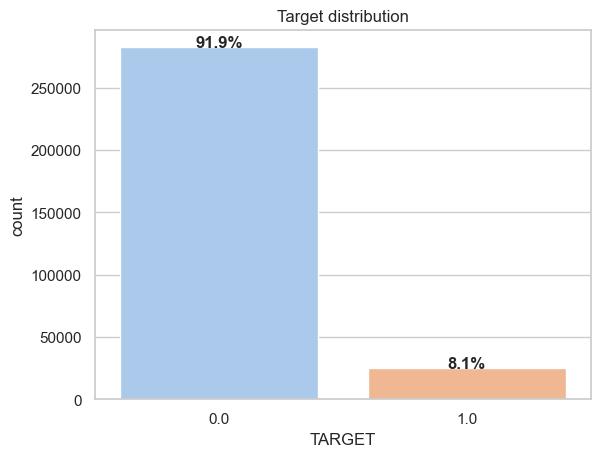

In [20]:
# Graphique de distribution de la target
colors = sns.color_palette('pastel')[0:2]
ax = sns.countplot(x='TARGET', data=dataset_target, palette=colors)
plt.title("Target distribution")

# calculer et ajouter les pourcentages
total_count = len(dataset_target)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', fontsize=12, fontweight='bold')

plt.show()

## Rebalancing data

Dans cette partie, nous allons utiliser SMOTE (Synthetic Minority Over-sampling Technique) pour gérer le déséquilibre de classe. SMOTE est une méthode d'oversampling qui génère synthétiquement des exemples de la classe minoritaire pour atteindre un équilibre entre les classes dans l'ensemble d'entraînement.

On applique SMOTE uniquement à l'ensemble d'entraînement (X_train, y_train) à l'intérieur d'un pipeline. Cela garantit que l'oversampling n'affecte que l'ensemble d'entraînement et laisse l'ensemble de test non modifié. Cela prévient le data leakage potentiel en maintenant la séparation entre les ensembles de données d'entraînement et de test.

In [22]:
# Séparer les features et la cible
X = dataset_target.drop(columns=["TARGET"])
y = dataset_target["TARGET"]

In [23]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [24]:
# Afficher les compteurs des classes dans les ensembles d'entraînement et de test
print("Training target:", Counter(y_train))
print("Testing target:", Counter(y_test))

Training target: Counter({0.0: 226145, 1.0: 19860})
Testing target: Counter({0.0: 56537, 1.0: 4965})


In [25]:
# Définir l'oversampling (SMOTE) et l'undersampling
over = SMOTE(sampling_strategy=0.5)  # Oversample pour obtenir un ratio de 1:2
under = RandomUnderSampler(sampling_strategy=1)  # Undersample pour obtenir un ratio de 1:1

In [26]:
# Définir le pipeline d'échantillonnage
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

In [29]:
# Appliquer SMOTE uniquement à l'ensemble d'entraînement
X_res, y_res = pipeline.fit_resample(X_train, y_train)

# Afficher les statistiques des cibles d'entraînement après SMOTE
print("Training target statistics after SMOTE:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics after SMOTE: Counter({0.0: 113072, 1.0: 113072})
Testing target statistics: Counter({0.0: 56537, 1.0: 4965})


## Baseline with several classifiers

Nous allons aborder deux aspects importants dans notre démarche d'élaboration du modèle, en tenant compte du contexte métier :

- La gestion du déséquilibre entre le nombre de bons et de moins bons clients : Dans le cadre de notre notebook, nous prendrons en considération ce déséquilibre lors de la création d'un modèle pertinent. Nous utiliserons au moins une méthode de gestion du déséquilibre.
- L'équilibre du coût métier entre un faux négatif (FN - prédiction d'un mauvais client en tant que bon client, entraînant l'octroi du crédit et une perte en capital) et un faux positif (FP - prédiction d'un bon client en tant que mauvais client, entraînant le refus du crédit et une perte de marge). Nous supposerons, par exemple, que le coût d'un FN est dix fois supérieur à celui d'un FP.


Nous créerons un score "métier" qui minimisera le coût des erreurs de prédiction à la fois pour les FN et les FP. Ce score nous permettra de comparer les modèles et de sélectionner le meilleur modèle ainsi que ses meilleurs hyperparamètres. Il est important de noter que cette minimisation du coût métier impliquera l'optimisation du seuil qui détermine la classe 0 ou 1 à partir d'une probabilité. Le seuil de 0.5 n'est pas nécessairement l'optimum dans ce contexte.

En parallèle, nous conserverons des mesures techniques telles que l'AUC et l'accuracy à des fins de comparaison et de contrôle.

In [30]:
# On définit les classificateurs à tester
classifiers = {
    "Dummy_Classifier" : DummyClassifier(strategy='stratified', random_state=42), 
    "Logistic_Regression" : LogisticRegression(random_state=42),
    "Random_Forest" : RandomForestClassifier(random_state=42),
    "XGBoost" : xgb.XGBClassifier(random_state=42),
    "LightGBM" : ltb.LGBMClassifier(random_state=42)
}

In [31]:
# On crée le score métier
business_score = make_scorer(fc_business_score)

In [45]:
LIST_DURATION = []  # Initialiser une liste vide pour stocker les durées d'exécution

# Initialiser le classificateur à l'extérieur de la boucle
classifier = None

for key, clf in classifiers.items():
    classifier = clf

    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1_macro',
        'roc_auc': 'roc_auc',
        'business': business_score
    }
    
    num_folds = 5
 
    start_time_model = timeit.default_timer()
    results = cross_validate(classifier, X_res, y_res, cv=num_folds, scoring=scoring)
    end_time_model = round(timeit.default_timer() - start_time_model, 3)
    LIST_DURATION.append(end_time_model)

    results_df = pd.DataFrame(results)

    globals()[key + "_mean_scores"] = results_df.mean()
    
    if key == "Dummy_Classifier" or key == "Logistic_Regression":
        log_mlflow(classifier, key, auc_score=globals()[key + "_mean_scores"]["test_roc_auc"], 
                   custom_score=-globals()[key + "_mean_scores"]["test_business"],
                   f1_score=globals()[key + "_mean_scores"]["test_f1"], 
                   acc_score=globals()[key + "_mean_scores"]["test_accuracy"],
                   train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])
   
    else:
        clf_params = classifier.get_params()
        log_mlflow(classifier, key,
                   custom_score=-globals()[key + "_mean_scores"]["test_business"],
                   auc_score=globals()[key + "_mean_scores"]["test_roc_auc"],
                   f1_score=globals()[key + "_mean_scores"]["test_f1"], 
                   acc_score=globals()[key + "_mean_scores"]["test_accuracy"],
                   n_estimator=clf_params.get('n_estimators'),
                   max_depth=clf_params.get('max_depth'), 
                   train_class_0=Counter(y_res)[0],
                   train_class_1=Counter(y_res)[1])
   
    if key not in ["Dummy_Classifier", "Logistic_Regression"]:
        # Faire des prédictions uniquement pour les modèles autres que DummyClassifier et LogisticRegression
        classifier_for_predictions = clf  # Utilisez un modèle différent pour les prédictions
        y_pred = classifier_for_predictions.predict(X_test)
        # Calculer ROC curve et AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        log_mlflow(classifier_for_predictions, key,
                   custom_score=None,
                   auc_score=auc,
                   f1_score=None,
                   acc_score=None,
                   train_class_0=None,
                   train_class_1=None)
    else:
        y_pred = None


TypeError: Expected sequence or array-like, got <class 'NoneType'>

In [46]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

In [ ]:
LIST_DURATION = []

for key, clf in classifiers.items():
    
    classifier = clf

    # Define the evaluation metrics you want to calculate
    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1_macro',
        'roc_auc': 'roc_auc',
        'business': business_score
    }
    
    # Perform 5-fold cross-validation with multiple metrics
    num_folds = 5
 
    start_time_model = timeit.default_timer()
    results = cross_validate(classifier, X_res, y_res, cv=num_folds, scoring=scoring)
    end_time_model = round(timeit.default_timer() - start_time_model, 3)
    LIST_DURATION.append(end_time_model)

    # Create a Pandas DataFrame from the results dictionary
    results_df = pd.DataFrame(results)

    # Calculate the mean of all scores for each metric
    globals()[key + "_mean_scores"] = results_df.mean()
    
    #Save logs
    if key == "Dummy_Classifier" or key == "Logistic_Regression":
        log_mlflow(classifier, key, auc_score=globals()[key + "_mean_scores"]["test_roc_auc"], 
                   custom_score=-globals()[key + "_mean_scores"]["test_business"],
        f1_score=globals()[key + "_mean_scores"]["test_f1"], 
        acc_score=globals()[key + "_mean_scores"]["test_accuracy"],
        train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])
   
    else:
        clf_params = classifier.get_params()
        log_mlflow(classifier, key,
                   custom_score=-globals()[key + "_mean_scores"]["test_business"],
                   auc_score=globals()[key + "_mean_scores"]["test_roc_auc"],
                   f1_score=globals()[key + "_mean_scores"]["test_f1"], 
                   acc_score=globals()[key + "_mean_scores"]["test_accuracy"],
                   n_estimator=clf_params['n_estimators'],
                   max_depth=clf_params['max_depth'], 
                   train_class_0=Counter(y_res)[0],
                   train_class_1=Counter(y_res)[1])

2024/01/21 19:19:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/4g/0gymfxsd0sn547tt2mm3mcdw0000gn/T/tmpmm16yae1/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback.
Setuptools is replacing distutils.


In [ ]:
# create result dataframe
for key, clf in classifiers.items():
    globals()[key + "_mean_scores"] = globals()[key + "_mean_scores"].to_frame()
    globals()[key + "_mean_scores"] = globals()[key + "_mean_scores"].T
    globals()[key + "_mean_scores"].insert(0, 'Model', key)

In [ ]:
# create result dataframe
dfs = []
for key, clf in classifiers.items():
    dfs.append(globals()[key + "_mean_scores"])
result = pd.concat(dfs, ignore_index=True)
result["test_business"] = abs(result["test_business"])

In [ ]:
result